# Laboratorium 01 — Wprowadzenie do analizy obrazów medycznych (DICOM i NIfTI)

W tym laboratorium rozpoczniemy pracę z medycznymi danymi obrazowymi. Poznamy podstawowe formaty (DICOM, NIfTI), sposoby wczytywania i eksploracji wolumenów 3D, przegląd najważniejszych metadanych oraz wykonamy proste przekształcenia i wizualizacje.

## Cele nauczania
- Zrozumienie różnic między formatami DICOM i NIfTI oraz kiedy ich używać.
- Wczytywanie obrazów z użyciem bibliotek: pydicom, SimpleITK, nibabel, nilearn.
- Odczyt i interpretacja metadanych.
- Podstawowe operacje na danych 3D: wybór przekrojów, progowanie, obliczanie gradientów (Sobel), przepróbkowanie (interpolacja danych).
- Przegląd i zapis danych do plików NIfTI.

## Zakres i przepływ pracy
1. DICOM: wczytanie pojedynczych plików, przegląd nagłówka i pikseli (pydicom, SimpleITK)
2. NIfTI: wczytanie wolumenu, macierz affine, orientacje, podstawowe przekroje (nibabel)
3. Wizualizacja 2D/3D: przekroje osiowe/koronalne/strzałkowe, proste układy figur (matplotlib, opcjonalnie nilearn)
4. Proste przekształcenia: progowanie, filtr Sobela 3D, filtracja medianowa
5. Resamplowanie i zapis: izotropizacja voxeli, zapis przetworzonych danych do NIfTI

## Dane do ćwiczeń
Dane powinny pobrać się automatycznie w ramach skryptu. Znajdują się one w folderze data lub /content/data (w przypadku Google Colab).

## Wymagane narzędzia i biblioteki
- Python 3.9+ oraz:
  - numpy, matplotlib
  - pydicom, SimpleITK
  - nibabel, nilearn
- Biblioteki należy zainstalować na początku skryptu jeśli pracujesz w Google Colab. Jeśli pracujesz lokalnie, to warto stworzyć środowisko conda lub venv.

## Typowe pułapki i wskazówki
- Orientacje i układy współrzędnych: DICOM zwykle używa LPS, wiele narzędzi neuro (nibabel/nilearn) preferuje RAS. Nie mieszaj konwencji bez kontroli affine.
- Jednostki i skale intensywności: CT (HU - Hounsfield Units) vs MR (wartości względne). Normalizuj lub standaryzuj dane przed progowaniem/filtracją.
- Spójny spacing: przed analizą porównawczą rozważ resamplowanie do voxeli izotropowych (np. 1×1×1 mm).
- Pamięć i wydajność: pracujemy na małych przykładach, ale na większych danych stosuje się lazy loading (dane nie są wczytywane od razu, tylko po wywołaniu), ogranicza rozmiar figur i liczbę kopii tablic.

Powodzenia! W kolejnych sekcjach przejdziemy od wczytania plików po zapis przetworzonych wolumenów i krótką analizę.

## 0) Instalacja bibliotek (jeśli potrzebne)

In [ ]:
# Uruchom, jeśli pojawi się błąd 'ModuleNotFoundError'
# !pip -q install scipy nibabel nilearn SimpleITK pydicom matplotlib numpy

In [6]:
pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 76.2 MB/s eta 0:00:00



## 1) Automatyczne pobranie przykładowych danych

Aby nie trzeba było samodzielnie uploadować danych, wczytamy:
- **DICOM**: przykładowe pliki z pakietu `pydicom` (CT, MR),
- **NIfTI**: mały wolumen MNI152 (szablon MRI mózgu) pobrany z `nilearn`.


In [7]:
import os, shutil, urllib.request
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
import SimpleITK as sitk
import pydicom
from pydicom.data import get_testdata_files

from scipy import ndimage as ndi

BASE = "/content/data" if os.path.isdir("/content") else "./data"
DATA_DIR = os.path.join(BASE, "lab01_data")
os.makedirs(DATA_DIR, exist_ok=True)

# --- DICOM ---
dicom_dir = os.path.join(DATA_DIR, "dicom")
os.makedirs(dicom_dir, exist_ok=True)

dicom_examples = ["CT_small.dcm", "MR_small.dcm", "SC_rgb.dcm"]
for name in dicom_examples:
    src = get_testdata_files(name)[0]
    dst = os.path.join(dicom_dir, name)
    shutil.copy(src, dst)
print("Skopiowano pliki DICOM:", os.listdir(dicom_dir))

# --- NIfTI ---
nifti_dir = os.path.join(DATA_DIR, "nifti")
os.makedirs(nifti_dir, exist_ok=True)

nifti_path = os.path.join(nifti_dir, "mni152.nii.gz")
try:
    from nilearn.datasets import load_mni152_template
    img = load_mni152_template(resolution=2)
    nib.save(img, nifti_path)
    print("Pobrano MNI152 przez nilearn:", nifti_path)
except Exception as e:
    print("Błąd nilearn:", e)
    url = "https://nipy.org/nibabel/_static/nifti_examples/nifti1.nii.gz"
    urllib.request.urlretrieve(url, nifti_path)
    print("Pobrano fallback NIfTI:", nifti_path)

print("Gotowe dane w:", DATA_DIR)


Skopiowano pliki DICOM: ['CT_small.dcm', 'SC_rgb.dcm', 'MR_small.dcm']
Pobrano MNI152 przez nilearn: /content/data/lab01_data/nifti/mni152.nii.gz
Gotowe dane w: /content/data/lab01_data



## Zadanie 1 – Wczytanie obrazu DICOM i metadane

1. Wykonaj ponizsze operacje dla każdego z pobranych plików testowych DICOM (nazwy w `dicom_examples`).
2. Metadane mogą być wczytane zarówno za pomocą biblioteki `pydicom` jak i `SimpleITK`.
3. Najpierw wczytaj plik za pomocą funkcji `pydicom.dcmread`.
4. Następnie wczytaj i wyświetl za pomocą funkcji `getattr` metadane takie jak: `"Modality", "Rows", "Columns", "PixelSpacing", "SliceThickness", "Manufacturer"`.
Przykład wczytania przykładowej wartości: `print("Photometric Interpretation:", getattr(img_dcm_pydicom, "PhotometricInterpretation", "brak"))`.
5. Wczytaj ten sam plik za pomocą funkcji `sitk.ReadImage`.
6. Wypisz wszystkie dostępne metadane dostępne w plikach. W tym celu wykorzystaj funkcji `img.GetMetaDataKeys()` oraz `img_dcm.GetMetaData(key)`.
7. Przeanalizuj dostępne metadane.
8. Wczytaj dane obrazowe za pomocą funkcji `sitk.GetArrayFromImage`, a następnie wyświetl dane za pomocą `matplotlib`.

Modality: CT
Rows: 128
Columns: 128
PixelSpacing: [0.661468, 0.661468]
SliceThickness: 5.000000
Manufacturer: GE MEDICAL SYSTEMS

--- Wszystkie metadane ---
0008|0005: ISO_IR 100
0008|0008: ORIGINAL\PRIMARY\AXIAL
0008|0012: 20040119
0008|0013: 072731
0008|0014: 1.3.6.1.4.1.5962.3
0008|0016: 1.2.840.10008.5.1.4.1.1.2
0008|0018: 1.3.6.1.4.1.5962.1.1.1.1.1.20040119072730.12322
0008|0020: 20040119
0008|0021: 19970430
0008|0022: 19970430
0008|0023: 19970430
0008|0030: 072730
0008|0031: 112749
0008|0032: 112936
0008|0033: 113008
0008|0050: 
0008|0060: CT
0008|0070: GE MEDICAL SYSTEMS
0008|0080: JFK IMAGING CENTER
0008|0090: 
0008|0201: -0500 
0008|1010: CT01_OC0
0008|1030: e+1 
0008|1090: RHAPSODE
0010|0010: CompressedSamples^CT1 
0010|0020: 1CT1
0010|0030: 
0010|0040: O 
0010|1010: 000Y
0010|1030: 0.000000
0010|21b0: 
0018|0010: ISOVUE300/100 
0018|0022: HELICAL MODE
0018|0050: 5.000000
0018|0060: 120 
0018|0088: 5.000000
0018|0090: 480.000000
0018|1020: 05
0018|1040: IV
0018|1100: 338.6716

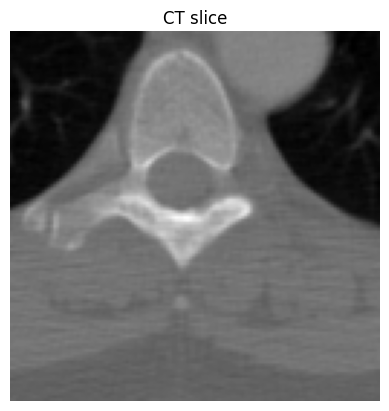

In [35]:
ct_small = pydicom.dcmread("/content/data/lab01_data/dicom/CT_small.dcm")

print("Modality:", getattr(ct_small, "Modality", "brak"))
print("Rows:", getattr(ct_small, "Rows", "brak"))
print("Columns:", getattr(ct_small, "Columns", "brak"))
print("PixelSpacing:", getattr(ct_small, "PixelSpacing", "brak"))
print("SliceThickness:", getattr(ct_small, "SliceThickness", "brak"))
print("Manufacturer:", getattr(ct_small, "Manufacturer", "brak"))

ct_small_2 = sitk.ReadImage("/content/data/lab01_data/dicom/CT_small.dcm")

print("\n--- Wszystkie metadane ---")
for key in ct_small_2.GetMetaDataKeys():
    print(f"{key}: {ct_small_2.GetMetaData(key)}")

array = sitk.GetArrayFromImage(ct_small_2)
print("\nKształt danych obrazowych:", array.shape)

plt.imshow(array[0], cmap="gray")
plt.title("CT slice")
plt.axis("off")
plt.show()


## Zadanie 2 – Wczytanie wolumenu NIfTI i przekroje

1. Wczytaj plik `mni152.nii.gz`. Ścieżka znajduje się w `nifti_path`. Wykorzystaj funkcję `nib.load`.
2. Wczytaj dane za pomocą funkcji `file.get_fdata()`.
3. Sprawdź kształt tablicy (`data.shape`), macierz affine (`file.affine`), spacing (`file.header.get_zooms()`) oraz kierunek osi `nib.aff2axcodes(nii.affine)`.
4. Wyświetl trzy środkowe przekroje: axial (poprzeczny - "od góry"), coronal (czołowy - "od przodu"), sagittal (strzałkowy - "od boku").


Kształt danych: (99, 117, 95)

Macierz affine:
 [[   2.    0.    0.  -98.]
 [   0.    2.    0. -134.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]

Spacing (rozmiar voxela w mm): (np.float32(2.0), np.float32(2.0), np.float32(2.0))

Kierunki osi: ('R', 'A', 'S')


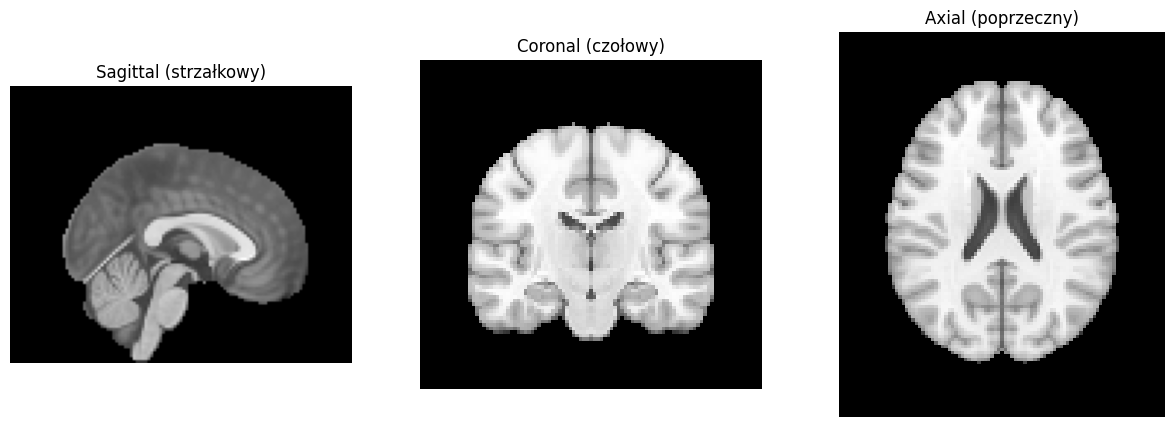

In [36]:
# --- Zadanie 2
nii = nib.load(nifti_path)
data = nii.get_fdata()
print("Kształt danych:", data.shape)
print("\nMacierz affine:\n", nii.affine)
print("\nSpacing (rozmiar voxela w mm):", nii.header.get_zooms())
print("\nKierunki osi:", nib.aff2axcodes(nii.affine))
x, y, z = data.shape

sagittal_slice = data[x // 2, :, :]
coronal_slice  = data[:, y // 2, :]
axial_slice    = data[:, :, z // 2]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(np.rot90(sagittal_slice), cmap="gray")
axes[0].set_title("Sagittal (strzałkowy)")
axes[0].axis("off")

axes[1].imshow(np.rot90(coronal_slice), cmap="gray")
axes[1].set_title("Coronal (czołowy)")
axes[1].axis("off")

axes[2].imshow(np.rot90(axial_slice), cmap="gray")
axes[2].set_title("Axial (poprzeczny)")
axes[2].axis("off")

plt.show()


## Zadanie 3 – Histogram i podstawowe operacje

1. Wyświetl histogram intensywności wolumenu (NIfTI) za pomocą funkcji `plt.hist`. W celu poprawy widoczności można ustawić `range=(0.01, 1)`. Wcześniej spłaszcz dane za pomocą metody `.ravel()`.
2. Wyświetl 3 oryginalne przekroje (jak w poprzednim zadaniu).
3. Oblicz gradient Sobela względem wszystkich trzech osi. Wykorzystaj funkcję `ndi.sobel`.
4. Za pomocą normy L2 połącz wyniki z wszystkich osi.
5. Wyświetl te same przekroje jak wcześniej.
6. Wykonaj progowanie dla 90-tego precentyla danych. Do wyznaczenia tej wartości wykorzystaj funkcję `np.percentile`.
7. Wykonaj progowania, a następnie zrzutuj wynik do typu `np.uint8`.
8. Wyświetl te same przekroje jak wcześniej.
9. Wykonaj filtrację medianową dla tych samych danych. Wykorzystaj funkcję `ndi.median_filter`.
10. Wyświetl te same przekroje jak wcześniej.


Shape: (99, 117, 95)


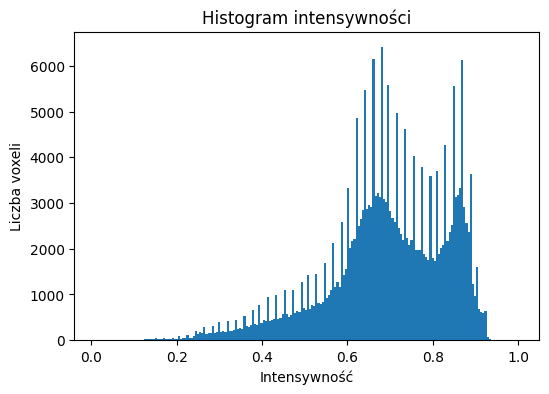

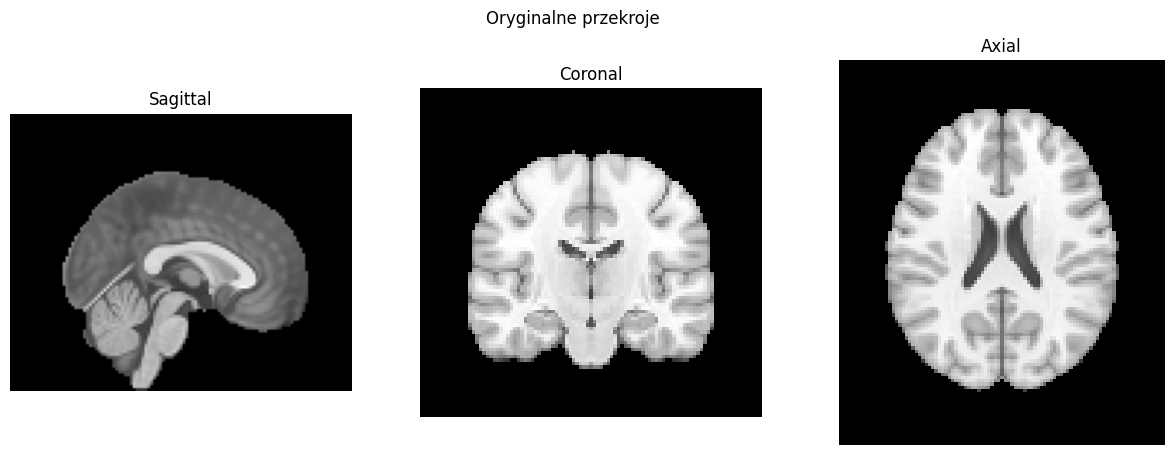

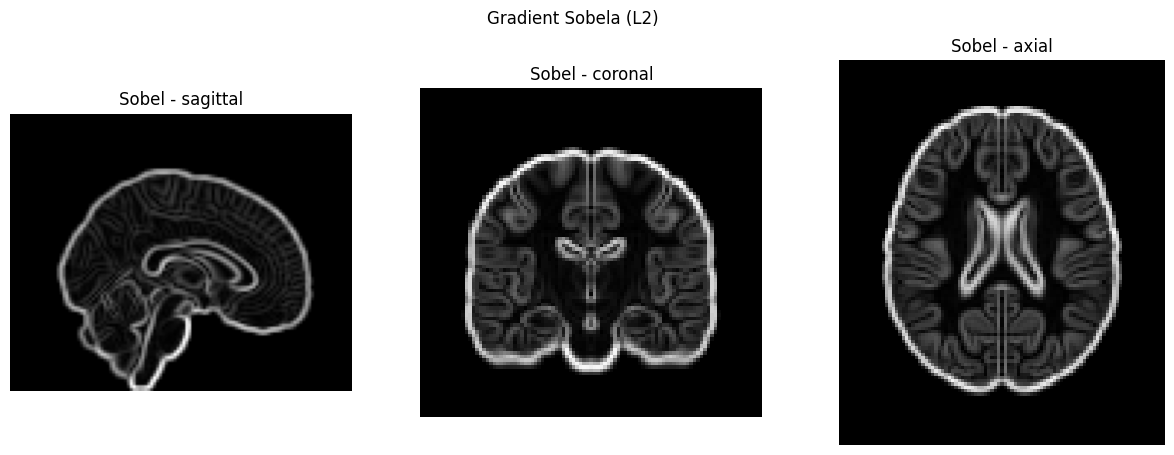

Wartość progowania (90 percentyl): 0.7098039388656616


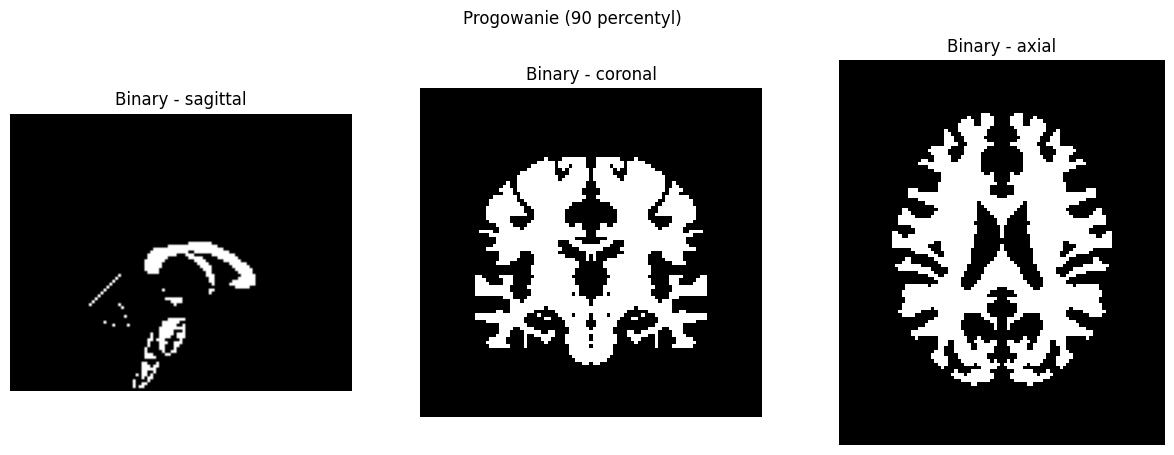

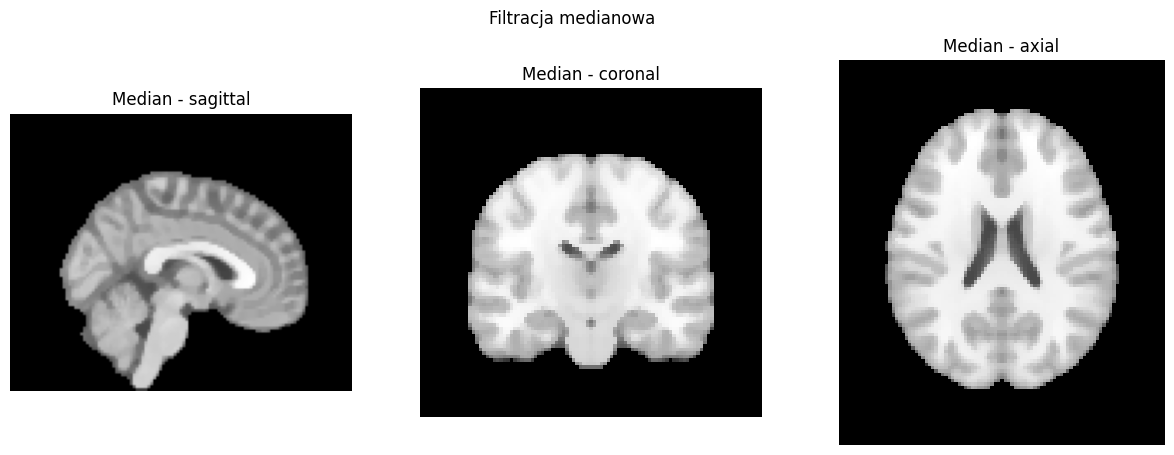

In [37]:
# --- Zadanie 3

nii = nib.load(nifti_path)
data = nii.get_fdata()

print("Shape:", data.shape)

# 1.
plt.figure(figsize=(6,4))
plt.hist(data.ravel(), bins=200, range=(0.01, 1))
plt.title("Histogram intensywności")
plt.xlabel("Intensywność")
plt.ylabel("Liczba voxeli")
plt.show()

# 2.
x, y, z = data.shape
sagittal = data[x//2, :, :]
coronal  = data[:, y//2, :]
axial    = data[:, :, z//2]

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(np.rot90(sagittal), cmap="gray"); axes[0].set_title("Sagittal"); axes[0].axis("off")
axes[1].imshow(np.rot90(coronal), cmap="gray"); axes[1].set_title("Coronal"); axes[1].axis("off")
axes[2].imshow(np.rot90(axial), cmap="gray"); axes[2].set_title("Axial"); axes[2].axis("off")
plt.suptitle("Oryginalne przekroje")
plt.show()

# 3.
sobel_x = ndi.sobel(data, axis=0)
sobel_y = ndi.sobel(data, axis=1)
sobel_z = ndi.sobel(data, axis=2)

sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2 + sobel_z**2)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(np.rot90(sobel_magnitude[x//2,:,:]), cmap="gray"); axes[0].set_title("Sobel - sagittal"); axes[0].axis("off")
axes[1].imshow(np.rot90(sobel_magnitude[:,y//2,:]), cmap="gray"); axes[1].set_title("Sobel - coronal"); axes[1].axis("off")
axes[2].imshow(np.rot90(sobel_magnitude[:,:,z//2]), cmap="gray"); axes[2].set_title("Sobel - axial"); axes[2].axis("off")
plt.suptitle("Gradient Sobela (L2)")
plt.show()

# 4.
threshold = np.percentile(data, 90)
print("Wartość progowania (90 percentyl):", threshold)

binary = (data > threshold).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(np.rot90(binary[x//2,:,:]), cmap="gray"); axes[0].set_title("Binary - sagittal"); axes[0].axis("off")
axes[1].imshow(np.rot90(binary[:,y//2,:]), cmap="gray"); axes[1].set_title("Binary - coronal"); axes[1].axis("off")
axes[2].imshow(np.rot90(binary[:,:,z//2]), cmap="gray"); axes[2].set_title("Binary - axial"); axes[2].axis("off")
plt.suptitle("Progowanie (90 percentyl)")
plt.show()

# 5.
median_filtered = ndi.median_filter(data, size=3)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(np.rot90(median_filtered[x//2,:,:]), cmap="gray"); axes[0].set_title("Median - sagittal"); axes[0].axis("off")
axes[1].imshow(np.rot90(median_filtered[:,y//2,:]), cmap="gray"); axes[1].set_title("Median - coronal"); axes[1].axis("off")
axes[2].imshow(np.rot90(median_filtered[:,:,z//2]), cmap="gray"); axes[2].set_title("Median - axial"); axes[2].axis("off")
plt.suptitle("Filtracja medianowa")
plt.show()


## Zadanie 4 – Resampling wolumenu do izotropowego voxela

1. Wczytaj dane NIfTI za pomocą `SimpleITK`. Wykorzystaj funkcję `sitk.ReadImage`.
2. Wyświetl rozmiar i spacing wczytanych danych. Wykorzystaj metody `.GetSize()` i `.GetSpacing()`.
3. Stwórz instancję klasy `sitk.ResampleImageFilter()`.
4. Wybierz metodę interpolacji za pomocą metody `.SetInterpolator`.
5. Wybierz wyjściowy spacing za pomocą metody `.SetOutputSpacing`. Chcemy uzyskać spacing 1mm dla każdej osi.
6. Ustaw orientację i położenie początka ukłądu współrzędnych jak w oryginalnych danych. Wykorzystaj metody `.SetOutputDirection`, `.GetDirection`, `.SetOutputOrigin` i `.GetOrigin`.
7. Oblicz rozmiar wyjściowych danych. Rozmiar dla analizowanego wymiaru powinien wynosić $Sz_o \cdot Sp_o / Sp_n$, gdzie $Sz_o$ jest originalnym rozmiarem, $Sp_o$ jest oryginalnym spacingiem, a $Sp_n$ jest docelowym spacingiem.
8. Ustaw docelowy rozmiar za pomocą metody `.SetSize`.
9. Wykonaj przeprobkowanie danych za pomocą metody `.Execute`.
10. Wyświetl rozmiar oraz spacing wyjściowych danych.

In [27]:
# --- Zadanie 4
# 1.
img = sitk.ReadImage(nifti_path)

# 2.
print("Oryginalny rozmiar:", img.GetSize())
print("Oryginalny spacing:", img.GetSpacing())

# 3.
resampler = sitk.ResampleImageFilter()

# 4.
resampler.SetInterpolator(sitk.sitkLinear)

# 5.
new_spacing = [1.0, 1.0, 1.0]
resampler.SetOutputSpacing(new_spacing)

# 6.
resampler.SetOutputDirection(img.GetDirection())
resampler.SetOutputOrigin(img.GetOrigin())

# 7.
orig_size = np.array(img.GetSize(), dtype=int)
orig_spacing = np.array(img.GetSpacing())
new_spacing = np.array(new_spacing)

new_size = (orig_size * (orig_spacing / new_spacing)).astype(int)
new_size = [int(s) for s in new_size]  # konwersja do listy intów

# 8.
resampler.SetSize(new_size)

# 9.
resampled_img = resampler.Execute(img)

# 10.
print("Nowy rozmiar:", resampled_img.GetSize())
print("Nowy spacing:", resampled_img.GetSpacing())


Oryginalny rozmiar: (99, 117, 95)
Oryginalny spacing: (2.0, 2.0, 2.0)
Nowy rozmiar: (198, 234, 190)
Nowy spacing: (1.0, 1.0, 1.0)



## Zadanie 5 – Zapis przetworzonego wolumenu w formacie NIfTI (LPS -> RAS)

1. Utwórz ścieżkę gdzie dane zostaną zapisane.
2. Wyciągnij dane `NumPy` z obrazu `SimpleITK`.
3. Dopasuj kolejność wymiarów do biblioteki `nibabel` - (z, y, x) -> (x, y, z). Wykorzystaj funkcję `np.transpose`.
4. Pobierz spacing, direction i origin dla zapisywanych danych. Zamień je na `np.array` typu `float`. Zmień kształt direction na `(3, 3)` metodą `.reshape`.
5. Wyświetl pobrane wartości.
6. Najpierw stwórz macierz affine dla formatu LPS (stosowany w `SimpleITK` i DICOM). Zacznij od stworzenia macierzy jednostkowej o rozmiarze $4 \times 4$. Następnie w trzy pierwsze kolumny i wiersze wpisz kolumny direction przeskalowane przez spacing (wystarczy operacja mnożenia element przez element - `*`). Do trzech pierwszych wierszy ostatniej kolumny wpisz origin.
7. Skonwertuj affine w formacie LPS do formatu RAS. W tym celu wystarczy odwrócić kierunki osi x i y. Można to zrobić wykonująć mnożenie macierzowe formatu lps przez macierz diagonalną o wartościach `[-1, -1, 1, 1]`. macierz diagonalną można stworzyć za pomocą `np.diag`.
8. Wyświetl obliczone affine. Porównaj go z affine oryginalnych danych, wczytanych na początku zadania 2.
9. Stwórz obraz NIfTI za pomocą `nib.Nifti1Image`. Pierwszym argumentem są dane jako tablica `NumPy`, a drugim affine w formacie RAS.
10. Wykonaj dodatkowo `nifti.set_sform(affine_ras, code=1)` i `nifti.set_qform(affine_ras, code=1)`.
11. Zapisz dane za pomocą `nib.save`.

sitk.GetArrayFromImage shape (z,y,x): (95, 117, 99)

Pobrane wartości:
spacing (sitk.GetSpacing): [2. 2. 2.]
direction (sitk.GetDirection) reshaped to 3x3:
 [[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
origin (sitk.GetOrigin): [ 98. 134. -72.]

Affine (LPS) obliczone z direction, spacing, origin:
 [[ -2.   0.   0.  98.]
 [  0.  -2.   0. 134.]
 [  0.   0.   2. -72.]
 [  0.   0.   0.   1.]]

Affine po konwersji LPS -> RAS:
 [[   2.    0.    0.  -98.]
 [   0.    2.    0. -134.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]

Zapisano NIfTI do: /content/data/lab01_data/nifti/output_nifti/mni152_from_sitk.nii.gz
Shape: (99, 117, 95)


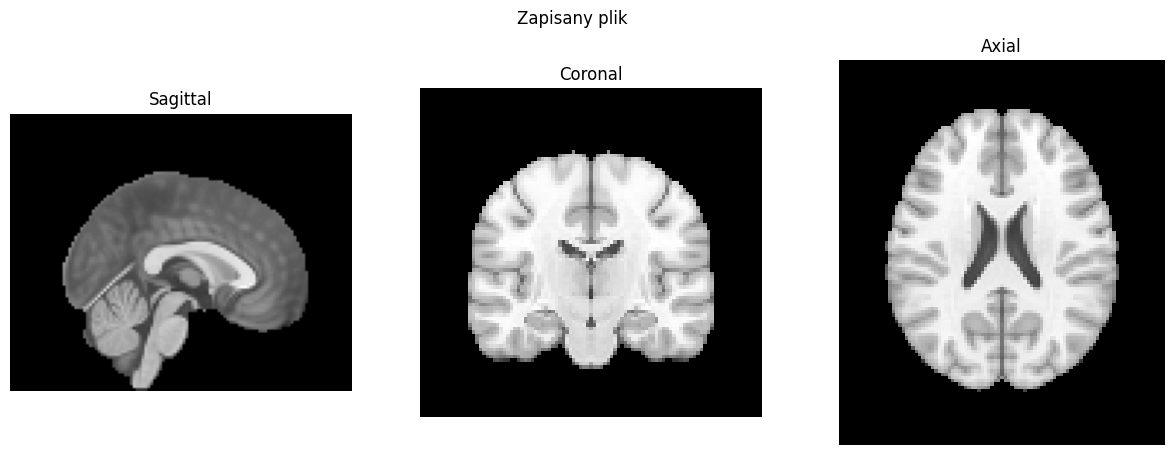

In [48]:
# --- Zadanie 5

# 1.
output_dir = "/content/data/lab01_data/nifti/output_nifti"
os.makedirs(output_dir, exist_ok=True)
out_fname = os.path.join(output_dir, "mni152_from_sitk.nii.gz")

sitk_array = sitk.GetArrayFromImage(img)
print("sitk.GetArrayFromImage shape (z,y,x):", sitk_array.shape)

# 2. 3.
numpy_data = np.transpose(sitk_array, (2, 1, 0))

# 4.
spacing = np.array(img.GetSpacing(), dtype=float)
direction = np.array(img.GetDirection(), dtype=float)
origin = np.array(img.GetOrigin(), dtype=float)

direction_matrix = direction.reshape(3, 3)

# 5.
print("\nPobrane wartości:")
print("spacing (sitk.GetSpacing):", spacing)
print("direction (sitk.GetDirection) reshaped to 3x3:\n", direction_matrix)
print("origin (sitk.GetOrigin):", origin)

# 6.
affine_lps = np.eye(4, dtype=float)
affine_lps[:3, :3] = direction_matrix @ np.diag(spacing)
affine_lps[:3, 3] = origin

print("\nAffine (LPS) obliczone z direction, spacing, origin:\n", affine_lps)

# 7.
D_full = np.diag([-1.0, -1.0, 1.0, 1.0])
affine_ras = D_full @ affine_lps

# 8.
print("\nAffine po konwersji LPS -> RAS:\n", affine_ras)

# 9.
numpy_data_to_save = numpy_data.astype(np.float32)
nifti_img = nib.Nifti1Image(numpy_data_to_save, affine_ras)

# 10.
nifti_img.set_sform(affine_ras, code=1)
nifti_img.set_qform(affine_ras, code=1)

# 11.
nib.save(nifti_img, out_fname)
print(f"\nZapisano NIfTI do: {out_fname}")

nii = nib.load(out_fname)
data = nii.get_fdata()
print("Shape:", data.shape)
x, y, z = data.shape
sagittal = data[x//2, :, :]
coronal  = data[:, y//2, :]
axial    = data[:, :, z//2]

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(np.rot90(sagittal), cmap="gray"); axes[0].set_title("Sagittal"); axes[0].axis("off")
axes[1].imshow(np.rot90(coronal), cmap="gray"); axes[1].set_title("Coronal"); axes[1].axis("off")
axes[2].imshow(np.rot90(axial), cmap="gray"); axes[2].set_title("Axial"); axes[2].axis("off")
plt.suptitle("Zapisany plik")
plt.show()


---
## Podsumowanie (do krótkiego uzupełnienia)

1. Jakie są główne różnice między DICOM a NIfTI?
2. Jakie metadane są ważne przy pracy z obrazami medycznymi?  
3. Jak interpretować trzy podstawowe przekroje wolumenu (axial, coronal, sagittal)?

Ad. 1.
DICOM na ogół jeden plik na jeden slice, a NIfTI ma cały wolumen 3D zapisany w jendym pliku.
DICOM setki atrybutów, NIfTI mniej.
Mają inne orientacje osi.

Ad. 2.
Spacing, rozmiar (liczba voxeli), affine (orientacja w przestrzeni).

Ad. 3.
Axial - poprzeczny, od góry.
Coronal - czołowy, od przodu.
Sagittal - strzałkowy, od boku.
